# Below cell is for: 
- loading the data using Kaggle API
- and using the data directly from google drive 

In [ ]:
# For uploading the kaggle.json file (specific to a user)

from google.colab import files
files.upload()

# get the data from kaggle

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

# Unzip the data
! mkdir nyc-airbnb-dataset
! unzip new-york-city-airbnb-open-data.zip -d nyc-airbnb-dataset
! rm -rf new-york-city-airbnb-open-data.zip

#### ^^ the cell output is intentionally not shown

### Note : everything above is stored in the content folder. 
###        to store it in drive, mount it

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
! mkdir gdrive/MyDrive/Colab\ Notebooks/Bayesian/datasets
! cp -rf /content/nyc-airbnb-dataset/ gdrive/MyDrive/Colab\ Notebooks/Bayesian/datasets 

mkdir: cannot create directory ‘gdrive/MyDrive/Colab Notebooks/Bayesian/datasets’: File exists


# 0. Bayesian Introduction (coin flip):

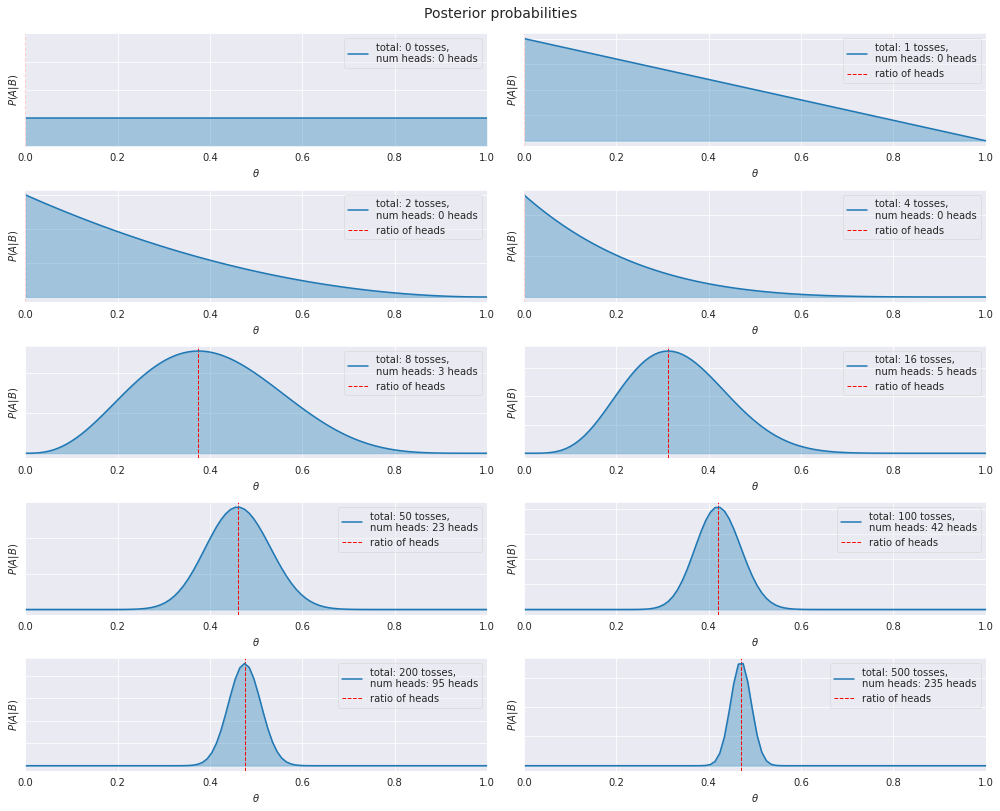

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

dist = stats.beta
trials = [0,1,2,4,8,16,50,100,200,500]
data = stats.bernoulli.rvs(0.5, size=trials[-1])
x = np.linspace(0, 1, 100)
plt.figure(figsize=(14,11))
sns.set_style('darkgrid')

for k, N in enumerate(trials):
  sx = plt.subplot(len(trials)//2, 2, k+1)
  plt.xlabel("$p$, probability of heads") if k in [0, len(trials)-1] else None
  plt.setp(sx.get_yticklabels(), visible=False)
  heads = data[:N].sum()
  y = dist.pdf(x, 1+heads, 1+N-heads)
  plt.plot(x, y, label="total: %d tosses,\nnum heads: %d heads" % (N, heads))
  plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
  ymin,ymax = sx.get_ylim()
  if k!=0:
    plt.vlines(heads/N, ymin,ymax, color="red", linestyles="--", lw=1, label='ratio of heads')
  else:
    plt.vlines(heads/N, 0, 4, color="red", linestyles="--", lw=1)

  leg = plt.legend()
  leg.get_frame().set_alpha(0.4)
  plt.autoscale(tight=True)
  sx.set_xlabel(r"$\theta$", fontsize=10)
  sx.set_ylabel(r"$P(A|B)$", fontsize=10)

plt.suptitle("Posterior probabilities",
             y=1.02,
             fontsize=14)
# plt.ylabel(r"$\dot{\Theta}$")
plt.tight_layout()

# 1. Data Exploration

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/content/nyc-airbnb-dataset/AB_NYC_2019.csv')
data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


# remove records with price = 0

In [8]:
data[data['price']==0]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
25778,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73
25794,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,2019-06-15,4.28,6,176
25795,20639792,Contemporary bedroom in brownstone with nice view,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,2019-06-21,4.37,6,232
25796,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,2019-06-23,4.35,6,222
26259,20933849,the best you can find,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,NaN,NaN,1,0
26841,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,2019-06-22,0.11,6,333


In [9]:
data = data[data['price']!=0].reset_index(drop=True)

In [10]:
# neigborhoods in NYC:

airbnb_summary_1 = data.groupby(['neighbourhood_group', 'neighbourhood'], as_index=False).agg({'room_type': 'count'}).rename(columns={'room_type': 'num_rooms'})
airbnb_summary_1.sort_values(['num_rooms'], ascending=False, inplace=True) 
airbnb_summary_1

,neighbourhood_group,neighbourhood,num_rooms
93,Brooklyn,Williamsburg,3919
50,Brooklyn,Bedford-Stuyvesant,3710
105,Manhattan,Harlem,2658
58,Brooklyn,Bushwick,2462
124,Manhattan,Upper West Side,1971
...,...,...,...
199,Staten Island,New Dorp,1
188,Staten Island,Fort Wadsworth,1
208,Staten Island,Rossville,1
206,Staten Island,Richmondtown,1


In [156]:
airbnb_summary_2 = airbnb_summary_1.groupby(['neighbourhood_group']).agg({'num_rooms': 'sum'})
airbnb_summary_2

,num_rooms
neighbourhood_group,
Bronx,1090
Brooklyn,20095
Manhattan,21660
Queens,5666
Staten Island,373


In [11]:
airbnb_summary_3 = data.pivot_table(index=['neighbourhood_group'], columns=['room_type'], values=['price'], aggfunc=['count', 'mean'])
airbnb_summary_3

count               ...         mean            
                              price               ...        price            
room_type           Entire home/apt Private room  ... Private room Shared room
neighbourhood_group                               ...                         
Bronx                           379          651  ...    66.890937   59.800000
Brooklyn                       9558        10126  ...    76.545428   50.773723
Manhattan                     13198         7982  ...   116.776622   88.977083
Queens                         2096         3372  ...    71.762456   69.020202
Staten Island                   176          188  ...    62.292553   57.444444

[5 rows x 6 columns]

## Lets try to keep it simple and only consider 'entire home/apt' type

In [12]:
data = data[data['room_type']=='Entire home/apt'].reset_index(drop=True)

In [159]:
data.pivot_table(index=['neighbourhood_group'], columns=['room_type'], values=['price'], aggfunc=['min', 'mean', 'max'])

,min,mean,max
,price,price,price
room_type,Entire home/apt,Entire home/apt,Entire home/apt
neighbourhood_group,,,
Bronx,28,127.506596,1000
Brooklyn,10,178.346202,10000
Manhattan,10,249.257994,10000
Queens,10,147.050573,2600
Staten Island,48,173.846591,5000


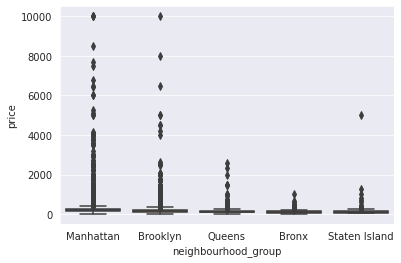

In [160]:
sns.set_style('darkgrid')
boxplot = sns.boxplot(x='neighbourhood_group', y='price', data=data)

### As you could see, the variance in the price of the entire apt is a lot in manhattan and brooklyn as the price heavily depends on different neighbourhoods within these boroughs.

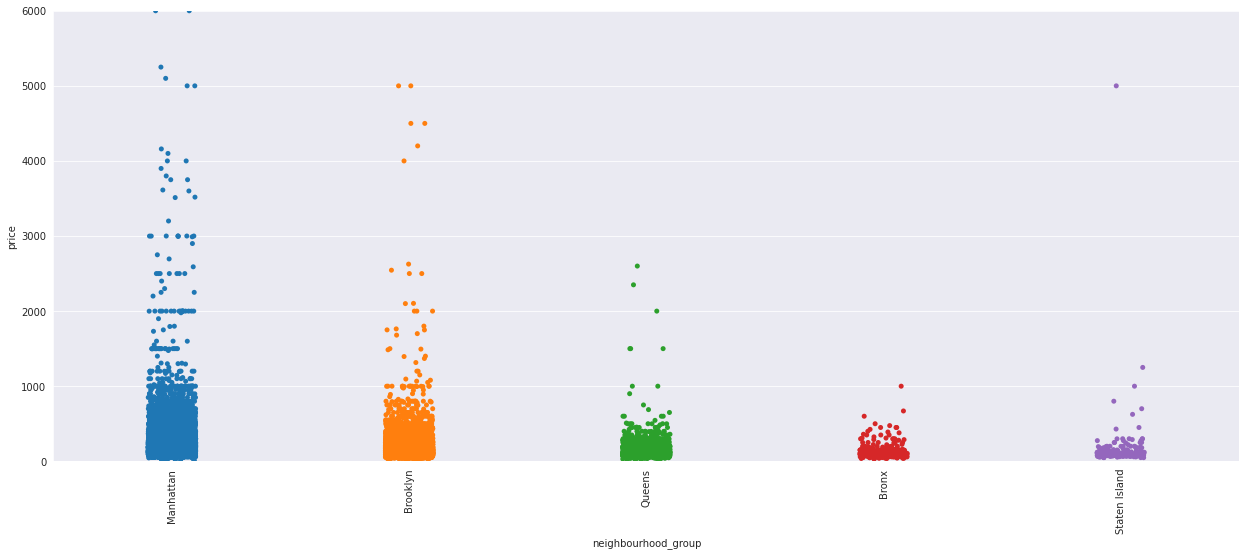

In [161]:
boxplot = sns.catplot(x='neighbourhood_group', y='price', data=data, height=7, aspect=2.5)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in boxplot.axes.flat]
boxplot.set(ylim=(0,6000))

#### The distribution of prices in Manhattan borough varies a lot based on the neigbourhood too

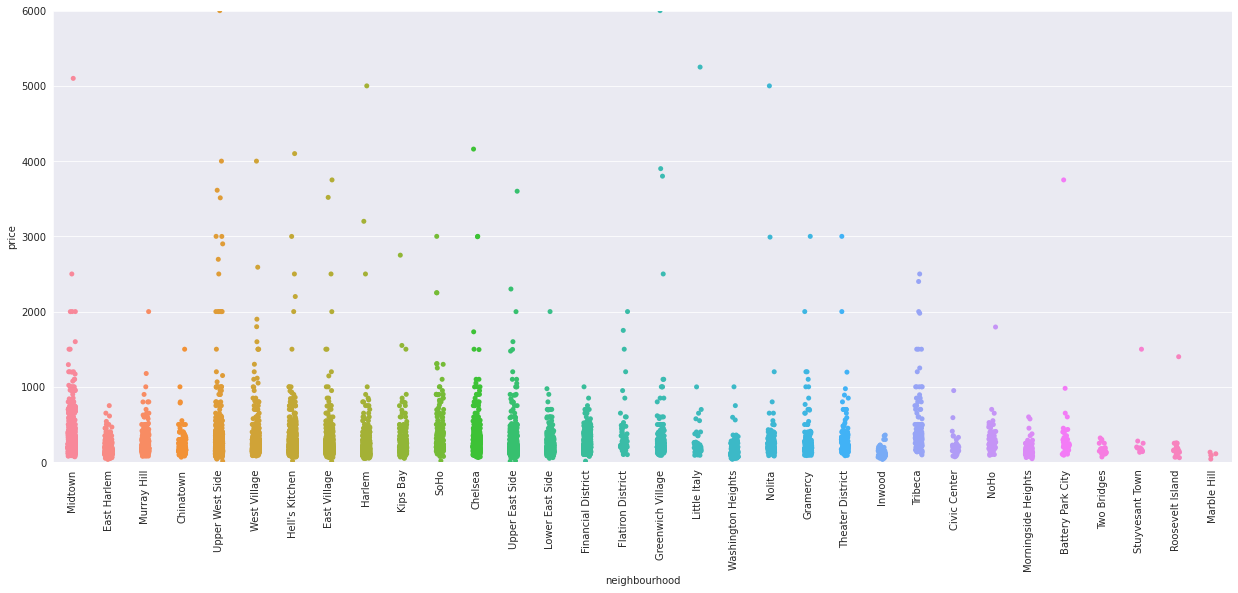

In [162]:
boxplot = sns.catplot(x='neighbourhood', y='price', data=data[data['neighbourhood_group']=='Manhattan'], height=7, aspect=2.5)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in boxplot.axes.flat]
boxplot.set(ylim=(0,6000))

### We see expensive apts in Upper West Side, West Village, Hell's Kitchen. The max price is above $4000. Also, the variance is considerable in these neighbourhoods too. 
### But for neighbourhoods like East Harlem, Financial District, Washington heights, the price barely goes above \$1000

# 2. ML problem statement:

## Lets say that we are interested in estimating the prices of apt type, 'Entire home/apt' in different neighborhoods of Manhattan:

- [Since this notebook is for understanding basis, we will keep the model very simple -> we will remove categorical variables and keep only the numeric features -  num_reviews, reviews_per_month, minimum_nights, host_listing_count]
- [If interested, you can go wild by using categorical features too and creating more user defined features like: distance from nearest metro, distance from famous landmarks like Empire State Building, Times Square, Brooklyn Bridge]

In [171]:
data_ML_X = data[['neighbourhood_group', 'neighbourhood', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']].copy()
data_ML_X.head(5)

,neighbourhood_group,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count
0,Manhattan,Midtown,1,45,0.38,2
1,Brooklyn,Clinton Hill,1,270,4.64,1
2,Manhattan,East Harlem,10,9,0.10,1
3,Manhattan,Murray Hill,3,74,0.59,1
4,Manhattan,Chinatown,1,160,1.33,4


### For simplicity again (for understanding purposes), lets consider only Manhattan borough for now, and 5 neighbourhoods - Midtown, East Harlem, Chinatown, Upper West Side, NoHo

In [172]:
filter = (data['neighbourhood_group']=='Manhattan') & (data['neighbourhood'].isin(['Midtown', 'East Harlem', 'Chinatown', 'Upper West Side', 'NoHo']))
data_ML_X = data_ML_X[filter].reset_index(drop=True)
data_ML_X.drop(columns=['neighbourhood_group'], inplace=True)

data_ML_y = data[filter]['price'].copy().reset_index(drop=True)
data_ML_X = data_ML_X.fillna(0)
data_ML_X.head(5)

,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count
0,Midtown,1,45,0.38,2
1,East Harlem,10,9,0.10,1
2,Chinatown,1,160,1.33,4
3,Upper West Side,5,53,0.43,1
4,East Harlem,7,0,0.00,2


In [173]:
# one hot encoding
data_ML_X = pd.get_dummies(data_ML_X)

In [174]:
# fixing the whitespace in the column name:
cols = data_ML_X.columns.tolist()
cols_new = []

for c in cols:
  if ' ' in c:
    cl = c.replace(' ', '_') 
    cols_new.append(cl)
  else:
    cols_new.append(c)

data_ML_X.columns = cols_new
cols = data_ML_X.columns.tolist()
data_ML_X.head(5)

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,neighbourhood_Chinatown,neighbourhood_East_Harlem,neighbourhood_Midtown,neighbourhood_NoHo,neighbourhood_Upper_West_Side
0,1,45,0.38,2,0,0,1,0,0
1,10,9,0.10,1,0,1,0,0,0
2,1,160,1.33,4,1,0,0,0,0
3,5,53,0.43,1,0,0,0,0,1
4,7,0,0.00,2,0,1,0,0,0


In [175]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def standardize_X(df, cols_to_standardize, use_fitted_scalar=None):

  x1 = df[cols_to_standardize]
  if use_fitted_scalar == None:
    scalar = StandardScaler()
    scaled_x1 = scalar.fit_transform(x1)
  else:
    scalar = use_fitted_scalar
    scaled_x1 = scalar.transform(x1)
  scaled_x1 = pd.DataFrame(scaled_x1, columns=cols_to_standardize)

  cols_not_to_standardize = [x for x in df.columns if x not in cols_to_standardize]
  x2 = df[cols_not_to_standardize]


  return scalar, pd.concat([scaled_x1, x2], axis=1)

In [176]:
# normalize X:
cols_to_standardize = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']
                      # note: standardizing can make the categorical values too small
                      #       which will make their coefficients very large while training 
scalar_X, data_scaled_X = standardize_X(data_ML_X, cols_to_standardize)

# normalize y: 
scalar_y  = StandardScaler()
data_scaled_y = scalar_y.fit_transform(np.array(data_ML_y).reshape(-1,1))
data_scaled_y = pd.DataFrame(data_scaled_y, columns=['price'])

In [178]:
from sklearn.linear_model import LinearRegression, Ridge

reg = Ridge(alpha=10).fit(data_scaled_X, data_scaled_y)

### Lets keep a different, more realistic test set for this problem:
- Lets say that we want to add a new listing in the airbnb for an entire apt for one night. What would the model estimate as a good target price to be?
- ^^ Remember that since the listing would be new, two of the field values would be 0 (ex: reviews, reviews per month).  
- Also, lets have a test set for each neighborhood in consideration (ie., Midtown, East Harlem, Chinatown, Upper West Side, NoHo)

In [124]:
test_set = pd.DataFrame(columns=cols)
neighbourhood = ['neighbourhood_Midtown', 'neighbourhood_East_Harlem', 'neighbourhood_Chinatown', 'neighbourhood_Upper_West_Side', 'neighbourhood_NoHo']

for i in range(5):
  inp = np.zeros(len(cols))
  np.put(inp, [0,3], 1)
  test_set.loc[i] = inp
  test_set.at[i, neighbourhood[i]] = 1

In [125]:
test_set

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,neighbourhood_Chinatown,neighbourhood_East_Harlem,neighbourhood_Midtown,neighbourhood_NoHo,neighbourhood_Upper_West_Side
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [126]:
_, test_set_scaled = standardize_X(test_set, cols_to_standardize, scalar_X)

In [127]:
predicted = reg.predict(test_set_scaled)
predicted = scalar_y.inverse_transform(predicted)
predicted_df = pd.DataFrame({'neighbourhood': neighbourhood})
predicted_df['LR_price'] = predicted
predicted_df

,neighbourhood,LR_price
0,neighbourhood_Midtown,311.250231
1,neighbourhood_East_Harlem,206.867151
2,neighbourhood_Chinatown,227.867685
3,neighbourhood_Upper_West_Side,272.501941
4,neighbourhood_NoHo,309.950572


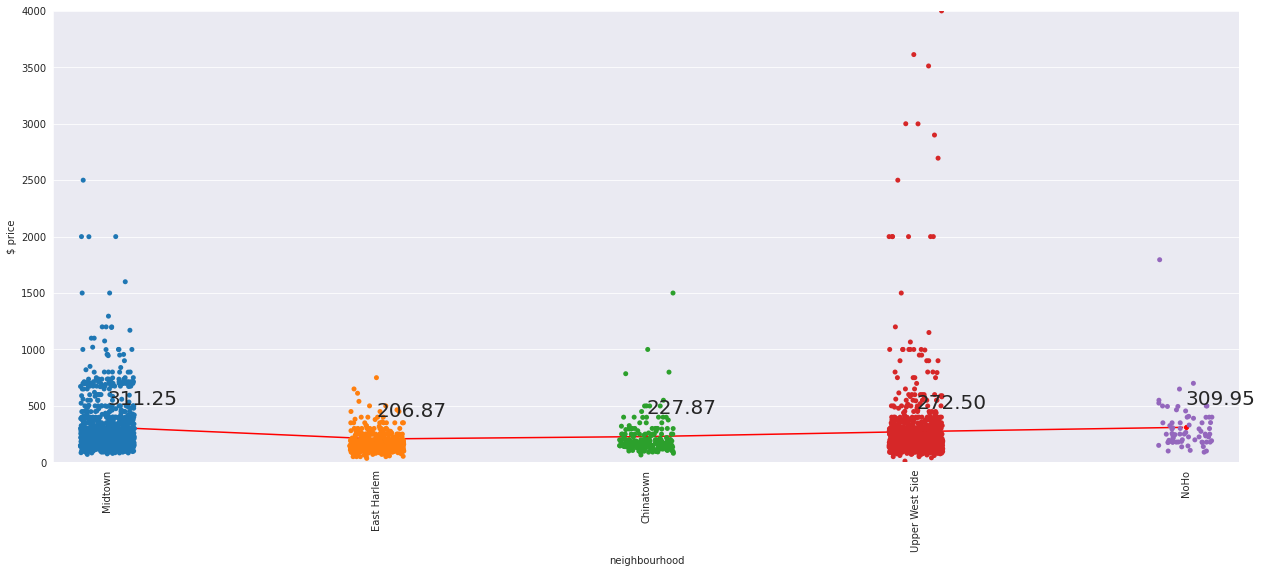

In [145]:
boxplot = sns.catplot(x='neighbourhood', y='price', data=data[filter], height=7, aspect=2.5)
sns.lineplot(x='neighbourhood', y='LR_price', data=predicted_df, color='red', marker='o')
for i,j in predicted_df[['neighbourhood','LR_price']].values:
  plt.text(i,j+200,f'{j:.2f}', fontsize=20)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in boxplot.axes.flat]
boxplot.set(ylim=(0,4000))
boxplot.set(ylabel='$ price')

# Bayesian Linear Regression

- A good guide for running bayesian linear regression using pymc3 is <a href='https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html'>pymc3 getting started module</a>

<u> Quick notes: </u>

<ul>
<li>Discrete output : Metropolis</li>
<li>Continuous output : NUTS (this is faster than other MCMC algorihtms </li>
<li>Binary output: BinaryMetropolis </li>
</ul>

In [181]:
import pymc3 as pm
import arviz as az

basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    beta = pm.Normal("beta", mu=0, sigma=10, shape=9)
    epsilon = pm.Normal("epsilon", mu=0, sigma=11)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = epsilon + beta*data_scaled_X

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=data_scaled_y)

In [36]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, epsilon, beta]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 24 seconds.


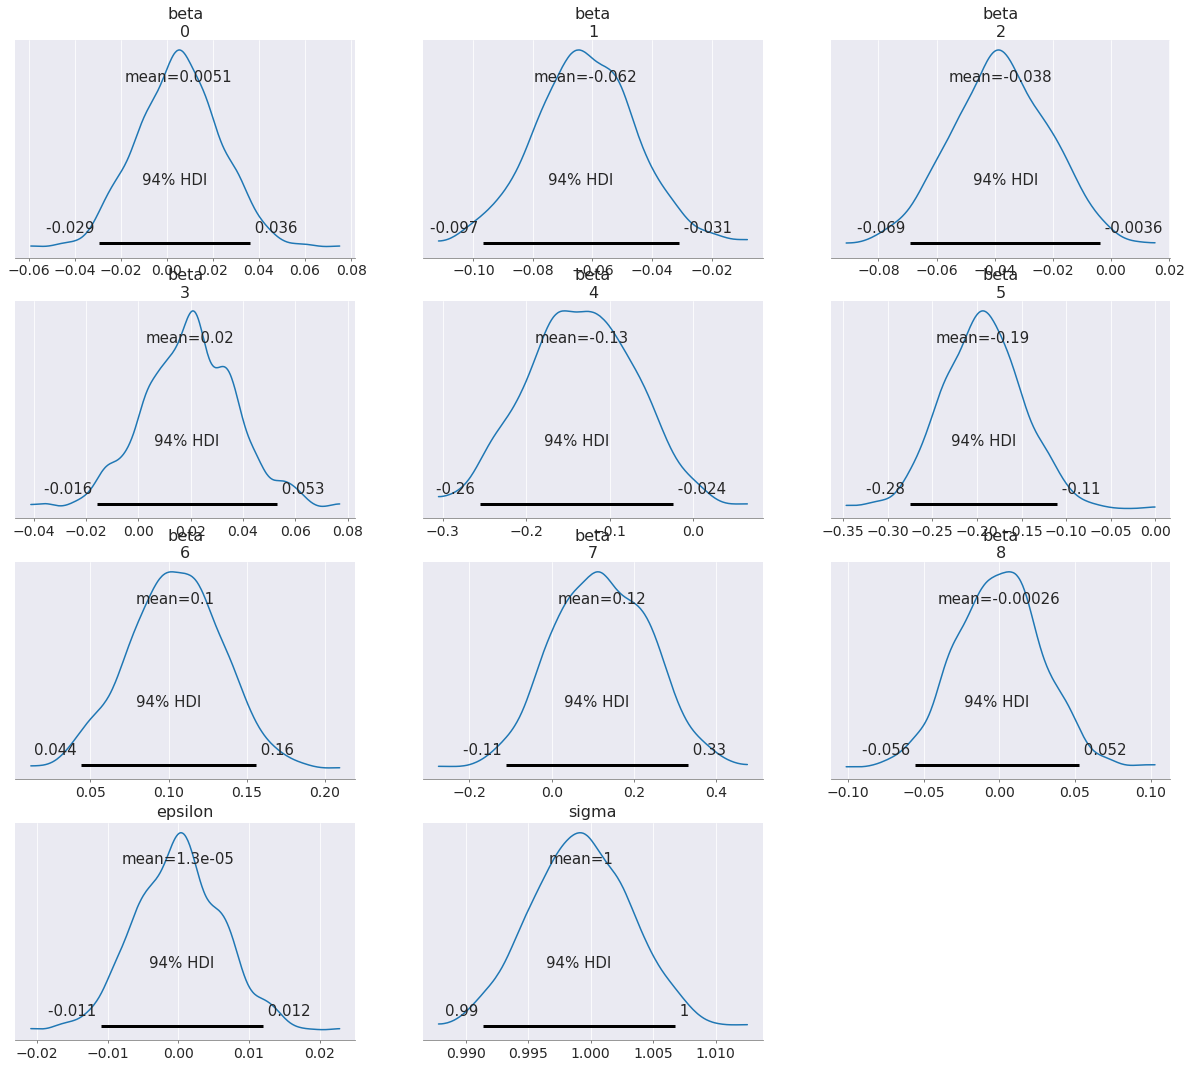

In [37]:
with basic_model:
  az.plot_posterior(trace)

## Using Bayesian Model results to make predictions

In [38]:
# getting the mean values of the parameters as estimates:

var_weights = {}
var_summary = pm.summary(trace)
var_weights['intercept'] = var_summary['mean']['epsilon']
for i, c in enumerate(cols):
  var_weights[c] = var_summary['mean']['beta['+str(i)+']']
var_weights = pd.DataFrame(var_weights, index=[0])

# storing the standard deviation -> useful for plotting prediction distribution
sd = trace['sigma'].mean()


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [39]:
# preparing test set input for bayesian LR:
# note that: the input is the same as before, but I am explicitly adding the intercept column with constant '1'
# (in sklearn, the intercept is added by default, and used during both training and inference)

bayes_test_set_scaled = np.append(np.ones((len(test_set_scaled), 1)), test_set_scaled, axis=1)
bayes_test_set_prediction_scaled = np.dot(bayes_test_set_scaled, np.array(var_weights).T)
bayes_test_set_prediction = scalar_y.inverse_transform(bayes_test_set_prediction_scaled)

In [115]:
bayes_predicted_df = pd.DataFrame(np.array([['Midtown'], ['East Harlem'], ['Chinatown'], ['Upper West Side'], ['NoHo']]), columns = ['neighbourhood_group'])
bayes_predicted_df['bayes_price'] = bayes_test_set_prediction
bayes_predicted_df

,neighbourhood_group,bayes_price
0,Midtown,317.940151
1,East Harlem,206.241331
2,Chinatown,228.731026
3,Upper West Side,278.958013
4,NoHo,324.687060


In [116]:
# adding output from ordinary LR:

bayes_predicted_df['Ordinary_LR_price'] = predicted_df['LR_price']
bayes_predicted_df

,neighbourhood_group,bayes_price,Ordinary_LR_price
0,Midtown,317.940151,311.250231
1,East Harlem,206.241331,206.867151
2,Chinatown,228.731026,227.867685
3,Upper West Side,278.958013,272.501941
4,NoHo,324.687060,309.950572


### From above you can see that the values are not very different. If interested, you can explore more on which model performs better by calculating the loss as well.

Prediction distribution plots

In [182]:
def test_prediction(var_weights, sd, test_observation, scalar_y, train_val=None, show_ols=False):

  # Ordinary LR output:
  test_observation = np.array(test_observation)
  test_observation = test_observation.reshape(1,-1)
  ols_output = reg.predict(test_observation)
  ols_output = scalar_y.inverse_transform(ols_output)

  # Bayesian output:
  test_observation = test_observation[0]
  intercept = np.array([1])
  test_observation = np.concatenate((intercept, test_observation))

  prediction_mean = np.dot(test_observation, np.array(var_weights).T)
  prediction_mean = prediction_mean.reshape(1,-1)
  prediction_mean = scalar_y.inverse_transform(prediction_mean)[0][0]
  
  # Plot the OLS estimate
  plt.figure(figsize=(10, 5))
  if show_ols:
    plt.vlines(x = ols_output, ymin = 0, ymax = 0.5, 
                linestyles = '-', colors = 'orange',
                label = 'OLS prediction',
              linewidth = 2.5)
  
  # plot the bayesian output distribution
  estimates = np.random.normal(loc = prediction_mean, scale = sd, size = 1000)
  
  sns.distplot(estimates, hist = True, kde = True, bins = 19,
                hist_kws = {'edgecolor': 'k', 'color': 'orange'},
              kde_kws = {'linewidth' : 4},
              label = 'Bayesian - Estimated Dist.')
  
  # summary stats:
  plt.legend(loc=1)
  plt.xlabel('$ price')
  print('OLS estimate = %0.4f' % ols_output)
  print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                      np.percentile(estimates, 95)))
  # return estimates

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


OLS estimate = 227.8677
5% Estimate = 227.1005    95% Estimate = 230.4067


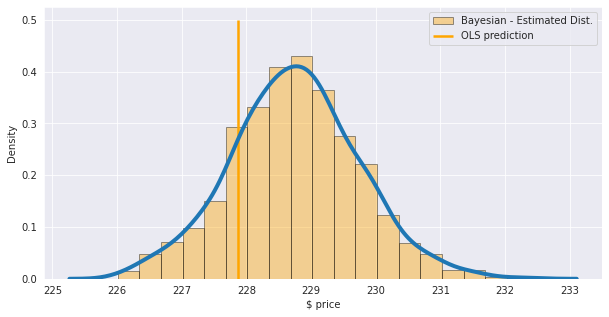

In [183]:
test_prediction(var_weights, sd, test_set_scaled.iloc[2], scalar_y,None, True)